In [82]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
%load_ext autoreload
%autoreload 2
import mmm_transformations
import mmm_preprocessing
import mmm_modeling
import mmm_response_curves
import mmm_optimization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [164]:
df = pd.read_csv('bioxcel_pr_definitive_id_level.csv')
df

,definitive_id,shipped_quantity,speaker_npi_ct,pp_imp_tot,pp_imp_desktop,pp_imp_mobile,pp_imp_set_top_box,pp_imp_tablet,pp_imp_connected_device,pp_imp_connected_tv,...,psychiatric_unit_beds,patients_discharged_on_multiple_antipsychotic_medications_with_appropriate_justification_rate,_hours_of_seclusion_rate,hours_of_physical_restraint_use_rate,total_revenues,operating_income,net_income,cash_on_hand,total_overhead_costs,est_#_of_er_visits
0,1,NaN,NaN,439.0,54.0,33.0,NaN,11.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24206.0
1,10,NaN,NaN,304.0,8.0,11.0,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.255917e+08,8662326.0,10179149.0,-603130.0,70656800.0,23942.0
2,100,NaN,NaN,921.0,130.0,106.0,NaN,122.0,NaN,NaN,...,64.0,NaN,NaN,NaN,1.948600e+08,-19954520.0,1993619.0,1004695.0,71063788.0,40957.0
3,1000,NaN,NaN,2318.0,260.0,204.0,NaN,317.0,NaN,NaN,...,NaN,NaN,NaN,NaN,3.016255e+09,-203828304.0,233810333.0,565857804.0,790585649.0,62952.0
4,1001,NaN,NaN,974.0,63.0,150.0,NaN,60.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.866081e+08,4931836.0,17967723.0,50996.0,96676127.0,30879.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,998613,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.351896e+07,3604365.0,3749577.0,29724.0,6055650.0,NaN
5404,998614,NaN,NaN,25.0,NaN,1.0,NaN,12.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.516627e+07,-857826.0,-413967.0,1500.0,8141901.0,NaN
5405,998615,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.017513e+07,-2721783.0,-2704887.0,-18088.0,8811603.0,NaN
5406,999,NaN,NaN,2115.0,125.0,300.0,NaN,154.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78364.0


In [168]:
df_pp = df.copy()
media = ['speaker_npi_ct', 'pp_imp_tot', 'rxnt_imp', 'webmd_imp_tot', 'call_tot']
binary = ['2023_targets']
financials = ['net_patient_revenue', 'net_income', 'operating_income', 'cash_on_hand', 'total_overhead_costs', 'total_revenues']
clinical = ['est_#_of_er_visits']
snr = [x for x in df_pp.columns if (x.startswith('anti')) | (x.startswith('benzo')) | (x.startswith('payor'))]
non_media_cat = ['formulary_type', 'segmentation', 'flag']
non_media_num = snr + financials + clinical
cols = ['definitive_id', 'shipped_quantity'] + media + non_media_cat + binary + non_media_num
df_pp = df_pp[cols]
# filter to only ordering accounts
df_pp = df_pp[df_pp['shipped_quantity'] > 0]
# replace nulls for media cols and shipped quantity with 0
for i in media + ['shipped_quantity'] + binary:
    df_pp[i] = df_pp[i].fillna(0)
# replace nulls for non media categorical columns with unknown
for i in non_media_cat:
    df_pp[i] = df_pp[i].fillna('Unknown')
# convert payor mix cols to float
for i in non_media_num:
    if i.startswith('payor'):
        df_pp[i] = df_pp[i].str.replace('%','').astype(float)
df_pp

,definitive_id,shipped_quantity,speaker_npi_ct,pp_imp_tot,rxnt_imp,webmd_imp_tot,call_tot,formulary_type,segmentation,flag,...,payor_mix_medicare_days,payor_mix_medicaid_days,payor_mix_private/self-pay/other_days,net_patient_revenue,net_income,operating_income,cash_on_hand,total_overhead_costs,total_revenues,est_#_of_er_visits
126,1047935,1.0,0.0,171.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,1265,1.0,0.0,229.0,208.0,0.0,25.0,Off Formulary,Unknown,Wave II,...,66.6,1.3,32.1,3.631582e+07,4006468.0,2242926.0,15285278.0,15527992.0,3.920547e+07,2170.0
580,1493,4.0,0.0,4.0,0.0,0.0,69.0,Off Formulary,Unknown,Unknown,...,32.4,4.2,63.3,1.194940e+08,20349000.0,1041294.0,3381000.0,35189153.0,1.393840e+08,21817.0
585,1499,1.0,0.0,0.0,0.0,0.0,32.0,Unknown,Unknown,Unknown,...,60.6,0.3,39.1,4.079917e+07,6180151.0,-7062443.0,21466237.0,10165534.0,5.415397e+07,5584.0
645,160,10.0,1.0,3495.0,1897.0,6.0,46.0,Accessible/non-formulary,B,Wave I,...,16.5,37.8,45.8,1.208254e+09,170334138.0,-123350474.0,62812159.0,666990401.0,1.501938e+09,102742.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,5948,9.0,0.0,210.0,0.0,0.0,6.0,Unknown,C,Wave II,...,0.4,7.2,92.4,1.389903e+07,243438.0,-12666708.0,NaN,12319857.0,2.680918e+07,NaN
4595,6084,11.0,3.0,47.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,2.8,NaN,97.2,2.944975e+07,24183239.0,-54637376.0,19139248.0,21196558.0,1.082704e+08,NaN
4600,6093,18.0,0.0,240.0,142.0,0.0,48.0,On Restricted,B,Wave I,...,1.2,0.1,98.7,5.482580e+07,-65199042.0,-10373181.0,-247186132.0,20483376.0,NaN,NaN
4921,743,1.0,0.0,2118.0,420.0,0.0,22.0,Accessible/non-formulary,D,Unknown,...,36.1,23.2,40.7,5.570451e+08,-31618556.0,4179596.0,85132642.0,289784442.0,5.694236e+08,93324.0


In [169]:
# imputation/NA statistics
for i in non_media_num:
    print(f"{i}:{len(df_pp[df_pp[i].isna()])}")

antipsychotic_im_iv_pack_units:8
antipsychotic_im_iv_volume_units:8
antipsychotic_im_iv_wac_dollars:8
antipsychotic_oral_pack_units:8
antipsychotic_oral_volume_units:8
antipsychotic_oral_wac_dollars:8
benzodiazepine_im_iv_pack_units:8
benzodiazepine_im_iv_volume_units:8
benzodiazepine_im_iv_wac_dollars:8
benzodiazepine_oral_pack_units:8
benzodiazepine_oral_volume_units:8
benzodiazepine_oral_wac_dollars:8
payor_mix_medicare_days:9
payor_mix_medicaid_days:16
payor_mix_private/self-pay/other_days:9
net_patient_revenue:12
net_income:9
operating_income:12
cash_on_hand:15
total_overhead_costs:9
total_revenues:14
est_#_of_er_visits:20


In [170]:
# one-hot encode non media categorical columns
preprocessing = mmm_preprocessing.MMMPreprocessing()
df_pp = preprocessing.one_hot(df_pp, non_media_cat)
df_pp

,definitive_id,shipped_quantity,speaker_npi_ct,pp_imp_tot,rxnt_imp,webmd_imp_tot,call_tot,formulary_type,segmentation,flag,...,formulary_type_On Restricted,formulary_type_Unknown,segmentation_A,segmentation_B,segmentation_C,segmentation_D,segmentation_Unknown,flag_Unknown,flag_Wave I,flag_Wave II
126,1047935,1.0,0.0,171.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,1,1,0,0
368,1265,1.0,0.0,229.0,208.0,0.0,25.0,Off Formulary,Unknown,Wave II,...,0,0,0,0,0,0,1,0,0,1
580,1493,4.0,0.0,4.0,0.0,0.0,69.0,Off Formulary,Unknown,Unknown,...,0,0,0,0,0,0,1,1,0,0
585,1499,1.0,0.0,0.0,0.0,0.0,32.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,1,1,0,0
645,160,10.0,1.0,3495.0,1897.0,6.0,46.0,Accessible/non-formulary,B,Wave I,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,5948,9.0,0.0,210.0,0.0,0.0,6.0,Unknown,C,Wave II,...,0,1,0,0,1,0,0,0,0,1
4595,6084,11.0,3.0,47.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,0,1,0,0,0,0,1,1,0,0
4600,6093,18.0,0.0,240.0,142.0,0.0,48.0,On Restricted,B,Wave I,...,1,0,0,1,0,0,0,0,1,0
4921,743,1.0,0.0,2118.0,420.0,0.0,22.0,Accessible/non-formulary,D,Unknown,...,0,0,0,0,0,1,0,1,0,0


In [285]:
for i in financials:
    df_pp[f"min_max_{i}"] = (df_pp[i] - np.min(df_pp[i]))/(np.max(df_pp[i]) - np.min(df_pp[i]))
df_pp['financials_min_max_sum'] = df_pp[[x for x in df_pp.columns if 'max' in x]].sum(axis=1)
df_pp['financial_health_score'] = (df_pp['financials_min_max_sum'] - np.min(df_pp['financials_min_max_sum']))/(np.max(df_pp['financials_min_max_sum']) - np.min(df_pp['financials_min_max_sum']))
df_pp = df_pp.drop([x for x in df_pp.columns if 'max' in x], axis=1)
df_pp

,definitive_id,shipped_quantity,speaker_npi_ct,pp_imp_tot,rxnt_imp,webmd_imp_tot,call_tot,formulary_type,segmentation,flag,...,formulary_type_Unknown,segmentation_A,segmentation_B,segmentation_C,segmentation_D,segmentation_Unknown,flag_Unknown,flag_Wave I,flag_Wave II,financial_health_score
126,1047935,1.0,0.0,171.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,1,0,0,0,0,1,1,0,0,0.000000
368,1265,1.0,0.0,229.0,208.0,0.0,25.0,Off Formulary,Unknown,Wave II,...,0,0,0,0,0,1,0,0,1,0.125136
580,1493,4.0,0.0,4.0,0.0,0.0,69.0,Off Formulary,Unknown,Unknown,...,0,0,0,0,0,1,1,0,0,0.134658
585,1499,1.0,0.0,0.0,0.0,0.0,32.0,Unknown,Unknown,Unknown,...,1,0,0,0,0,1,1,0,0,0.126074
645,160,10.0,1.0,3495.0,1897.0,6.0,46.0,Accessible/non-formulary,B,Wave I,...,0,0,1,0,0,0,0,1,0,0.340211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,5948,9.0,0.0,210.0,0.0,0.0,6.0,Unknown,C,Wave II,...,1,0,0,1,0,0,0,0,1,0.076176
4595,6084,11.0,3.0,47.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,1,0,0,0,0,1,1,0,0,0.127816
4600,6093,18.0,0.0,240.0,142.0,0.0,48.0,On Restricted,B,Wave I,...,0,0,1,0,0,0,0,1,0,0.075201
4921,743,1.0,0.0,2118.0,420.0,0.0,22.0,Accessible/non-formulary,D,Unknown,...,0,0,0,0,1,0,1,0,0,0.218586


In [286]:
df_pp.columns.tolist()

['definitive_id',
 'shipped_quantity',
 'speaker_npi_ct',
 'pp_imp_tot',
 'rxnt_imp',
 'webmd_imp_tot',
 'call_tot',
 'formulary_type',
 'segmentation',
 'flag',
 '2023_targets',
 'antipsychotic_im_iv_pack_units',
 'antipsychotic_im_iv_volume_units',
 'antipsychotic_im_iv_wac_dollars',
 'antipsychotic_oral_pack_units',
 'antipsychotic_oral_volume_units',
 'antipsychotic_oral_wac_dollars',
 'benzodiazepine_im_iv_pack_units',
 'benzodiazepine_im_iv_volume_units',
 'benzodiazepine_im_iv_wac_dollars',
 'benzodiazepine_oral_pack_units',
 'benzodiazepine_oral_volume_units',
 'benzodiazepine_oral_wac_dollars',
 'payor_mix_medicare_days',
 'payor_mix_medicaid_days',
 'payor_mix_private/self-pay/other_days',
 'net_patient_revenue',
 'net_income',
 'operating_income',
 'cash_on_hand',
 'total_overhead_costs',
 'total_revenues',
 'est_#_of_er_visits',
 'formulary_type_Accessible/non-formulary',
 'formulary_type_Off Formulary',
 'formulary_type_On Formulary',
 'formulary_type_On Restricted',
 'for

In [42]:
df_pp.to_csv('bioxcel_pr_time_series_for_modeling.csv', index=False)

# Transformations 

In [287]:
df_t = df_pp.copy()
df_t

,definitive_id,shipped_quantity,speaker_npi_ct,pp_imp_tot,rxnt_imp,webmd_imp_tot,call_tot,formulary_type,segmentation,flag,...,formulary_type_Unknown,segmentation_A,segmentation_B,segmentation_C,segmentation_D,segmentation_Unknown,flag_Unknown,flag_Wave I,flag_Wave II,financial_health_score
126,1047935,1.0,0.0,171.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,1,0,0,0,0,1,1,0,0,0.000000
368,1265,1.0,0.0,229.0,208.0,0.0,25.0,Off Formulary,Unknown,Wave II,...,0,0,0,0,0,1,0,0,1,0.125136
580,1493,4.0,0.0,4.0,0.0,0.0,69.0,Off Formulary,Unknown,Unknown,...,0,0,0,0,0,1,1,0,0,0.134658
585,1499,1.0,0.0,0.0,0.0,0.0,32.0,Unknown,Unknown,Unknown,...,1,0,0,0,0,1,1,0,0,0.126074
645,160,10.0,1.0,3495.0,1897.0,6.0,46.0,Accessible/non-formulary,B,Wave I,...,0,0,1,0,0,0,0,1,0,0.340211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,5948,9.0,0.0,210.0,0.0,0.0,6.0,Unknown,C,Wave II,...,1,0,0,1,0,0,0,0,1,0.076176
4595,6084,11.0,3.0,47.0,0.0,0.0,0.0,Unknown,Unknown,Unknown,...,1,0,0,0,0,1,1,0,0,0.127816
4600,6093,18.0,0.0,240.0,142.0,0.0,48.0,On Restricted,B,Wave I,...,0,0,1,0,0,0,0,1,0,0.075201
4921,743,1.0,0.0,2118.0,420.0,0.0,22.0,Accessible/non-formulary,D,Unknown,...,0,0,0,0,1,0,1,0,0,0.218586


# EDA

In [189]:
fig = px.histogram(df_t, x="shipped_quantity", nbins=20)
fig.show()

In [290]:
cor, features, cts = [], [], []
for i in channels + non_media_num + ['financial_health_score']:
    df_filt = df_t[~df_t[i].isna()]
    cor.append(np.corrcoef(df_filt['shipped_quantity'], df_filt[i])[0][1])
    cts.append(len(df_filt[df_filt[i]!=0]))
    features.append(i)
pd.DataFrame({'feature': features, 'cor': cor, 'n': cts}).sort_values(['cor'], ascending=False)

,feature,cor,n
6,antipsychotic_im_iv_volume_units,0.248224,61
5,antipsychotic_im_iv_pack_units,0.159272,61
4,call_tot,0.122743,53
8,antipsychotic_oral_pack_units,0.083873,61
9,antipsychotic_oral_volume_units,0.068931,61
19,payor_mix_private/self-pay/other_days,0.065814,60
10,antipsychotic_oral_wac_dollars,0.037701,61
18,payor_mix_medicaid_days,0.028523,52
0,speaker_npi_ct,0.022631,7
7,antipsychotic_im_iv_wac_dollars,0.019973,61


In [264]:
df_t[['shipped_quantity'] + channels + non_media_num].corr().reset_index().sort_values(['shipped_quantity'], ascending=False)

,index,shipped_quantity,speaker_npi_ct,pp_imp_tot,rxnt_imp,webmd_imp_tot,call_tot,antipsychotic_im_iv_pack_units,antipsychotic_im_iv_volume_units,antipsychotic_im_iv_wac_dollars,...,payor_mix_medicare_days,payor_mix_medicaid_days,payor_mix_private/self-pay/other_days,net_patient_revenue,net_income,operating_income,cash_on_hand,total_overhead_costs,total_revenues,est_#_of_er_visits
0,shipped_quantity,1.000000,0.022631,-0.107491,-0.073194,-0.064609,0.122743,0.159272,0.248224,0.019973,...,-0.099302,0.028523,0.065814,-0.125052,-0.059959,-0.025785,-0.180250,-0.113832,-0.111754,-0.022489
7,antipsychotic_im_iv_volume_units,0.248224,0.136615,-0.116214,-0.077074,-0.064764,-0.084960,0.473028,1.000000,0.364123,...,-0.532891,-0.136608,0.550052,0.050120,-0.317243,-0.181216,-0.088080,0.065370,0.187029,0.468282
6,antipsychotic_im_iv_pack_units,0.159272,-0.023536,0.407650,0.340982,0.079948,0.062619,1.000000,0.473028,0.417455,...,-0.380675,0.020973,0.335051,0.547844,-0.215594,-0.305577,0.299512,0.438001,0.592718,0.625068
5,call_tot,0.122743,-0.057973,0.196386,0.162358,0.031167,1.000000,0.062619,-0.084960,-0.027626,...,0.007736,-0.132089,0.033893,-0.027151,-0.074658,-0.051358,-0.000624,-0.023225,-0.038871,0.119442
9,antipsychotic_oral_pack_units,0.083873,0.329245,-0.084861,-0.151595,-0.101875,-0.099486,0.490771,0.717821,0.524831,...,-0.530611,-0.024338,0.515986,0.109888,-0.459626,-0.253032,-0.007957,0.055111,0.236349,0.658455
10,antipsychotic_oral_volume_units,0.068931,0.276825,-0.096285,-0.138291,-0.086247,-0.102490,0.496093,0.669956,0.491971,...,-0.493296,-0.024688,0.491195,0.108635,-0.524371,-0.233486,0.008322,0.041531,0.209680,0.596291
20,payor_mix_private/self-pay/other_days,0.065814,0.182176,0.028299,0.031546,-0.119902,0.033893,0.335051,0.550052,0.215577,...,-0.810681,-0.563829,1.000000,-0.022830,-0.047999,-0.070776,-0.133037,-0.046839,0.057116,0.278171
11,antipsychotic_oral_wac_dollars,0.037701,0.540622,-0.116726,-0.143326,-0.115656,-0.074501,0.367670,0.606472,0.488601,...,-0.486203,-0.068343,0.490161,-0.066298,-0.413719,-0.173350,-0.093495,-0.043375,0.017977,0.509301
19,payor_mix_medicaid_days,0.028523,0.055470,-0.108150,-0.024813,0.211661,-0.132089,0.020973,-0.136608,0.036903,...,-0.102154,1.000000,-0.563829,0.061664,0.060640,0.052425,0.040246,0.066683,0.042499,0.028070
1,speaker_npi_ct,0.022631,1.000000,-0.023649,-0.027808,0.039680,-0.057973,-0.023536,0.136615,0.227348,...,-0.207847,0.055470,0.182176,-0.056101,-0.038554,-0.053345,-0.036554,-0.014948,-0.053477,0.253569


In [291]:
features, cts = [], []
df_out = pd.DataFrame()
for i in [x for x in df_t.columns if (x.startswith('formulary_type_'))]:
    df_filt = df_t[df_t[i]==1]
    features.append(i)
    cts.append(len(df_filt))
    df_out = pd.concat([df_out, pd.DataFrame(df_filt[financials + ['financial_health_score'] + ['shipped_quantity']].median()).T])
df_out['feature'] = features
df_out['counts'] = cts
df_out

,net_patient_revenue,net_income,operating_income,cash_on_hand,total_overhead_costs,total_revenues,financial_health_score,shipped_quantity,feature,counts
0,625248690.0,88537464.0,-18390816.0,62812159.0,289784442.0,732176970.0,0.218586,6.0,formulary_type_Accessible/non-formulary,3
0,110032305.0,4673096.0,1642110.0,4898560.5,35189153.0,121488971.0,0.125136,3.0,formulary_type_Off Formulary,11
0,128712384.0,1722159.0,-3971848.0,1136239.5,60982204.0,132314051.0,0.130537,2.0,formulary_type_On Formulary,21
0,627367408.5,27850038.0,-7243038.5,18359717.0,118473090.5,827946439.0,0.209653,4.0,formulary_type_On Restricted,8
0,398882645.0,7819560.0,-12666708.0,19139248.0,174364057.0,430483562.0,0.125564,1.0,formulary_type_Unknown,26


In [292]:
features, cts = [], []
df_out = pd.DataFrame()
for i in [x for x in df_t.columns if (x.startswith('formulary_type_'))]:
    df_filt = df_t[df_t[i]==1]
    features.append(i)
    cts.append(len(df_filt))
    df_out = pd.concat([df_out, pd.DataFrame(df_filt[financials + ['financial_health_score'] + ['shipped_quantity']].mean()).T])
df_out['feature'] = features
df_out['counts'] = cts
df_out

,net_patient_revenue,net_income,operating_income,cash_on_hand,total_overhead_costs,total_revenues,financial_health_score,shipped_quantity,feature,counts
0,7.968491e+08,7.575102e+07,-4.585390e+07,4.951573e+07,3.920832e+08,9.345129e+08,0.256372,5.666667,formulary_type_Accessible/non-formulary,3
0,1.939556e+08,-3.419555e+07,-7.329297e+07,1.040516e+07,1.103141e+08,2.705431e+08,0.115167,3.272727,formulary_type_Off Formulary,11
0,2.187645e+08,4.604027e+06,-1.960724e+07,6.110884e+06,1.233192e+08,2.413219e+08,0.137150,5.809524,formulary_type_On Formulary,21
0,5.444497e+08,9.356841e+06,-4.247581e+06,1.538768e+07,1.417411e+08,7.436604e+08,0.187825,5.375000,formulary_type_On Restricted,8
0,7.484083e+08,2.297501e+08,6.918062e+07,8.933131e+07,2.957555e+08,9.066335e+08,0.186135,3.461538,formulary_type_Unknown,26


In [266]:
print(np.mean(df_t['shipped_quantity']))
print(np.median(df_t['shipped_quantity']))

4.463768115942029
2.0


In [267]:
cat_cols = binary + [x for x in df_t.columns if (x.startswith('formulary_type_')) | (x.startswith('segmentation_')) | (x.startswith('flag_'))]
means, features, cts = [], [], []
for i in cat_cols:
    df_filt = df_t[df_t[i] == 1]
    means.append(np.mean(df_filt['shipped_quantity']))
    cts.append(len(df_filt))
    features.append(i)
pd.DataFrame({'feature': features, 'mean': means, 'n': cts}).sort_values(['mean'], ascending=False)

,feature,mean,n
12,flag_Wave I,7.000000,19
7,segmentation_B,6.461538,13
3,formulary_type_On Formulary,5.809524,21
1,formulary_type_Accessible/non-formulary,5.666667,3
4,formulary_type_On Restricted,5.375000,8
0,2023_targets,5.113636,44
10,segmentation_Unknown,4.655172,29
8,segmentation_C,4.600000,10
6,segmentation_A,4.166667,6
13,flag_Wave II,4.000000,18


In [272]:
# fillna for non media numeric columns with mean for modeling
df_m = df_t.copy()
for i in non_media_num:
    df_m[i] = df_m[i].fillna(np.mean(df_m[i]))

# Ridge

In [273]:
# fit ridge
channels = ['speaker_npi_ct', 'pp_imp_tot', 'rxnt_imp', 'webmd_imp_tot', 'call_tot']
other = non_media_num + binary + [x for x in df_m.columns if (x.startswith('formulary_type_')) | (x.startswith('segmentation_')) | (x.startswith('flag_'))]
X = df_m[channels + other]
y = df_m['shipped_quantity']
# min max scale x values
for i in channels + non_media_num:
    X[i] = (X[i] - min(X[i]))/(max(X[i]) - min(X[i]))
# train test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# model fitting
ridge_full = Ridge(alpha=1.0).fit(X, y)
ridge_train = Ridge(alpha=1.0).fit(x_train, y_train)
# predictions
X['preds_full'] = ridge_full.predict(X)
x_train['preds_train'] = ridge_train.predict(x_train)
x_test['preds_test'] = ridge_train.predict(x_test)
# performance
perf = {'full': {'r2': r2_score(y, X['preds_full']), 'rmse': mean_squared_error(y, X['preds_full'], squared=False)},
        'train': {'r2': r2_score(y_train, x_train['preds_train']), 'rmse': mean_squared_error(y_train, x_train['preds_train'], squared=False)},
        'test': {'r2': r2_score(y_test, x_test['preds_test']), 'rmse': mean_squared_error(y_test, x_test['preds_test'], squared=False)}}
perf

c:\program files (x86)\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\program files (x86)\python\python37-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'full': {'r2': 0.4218216117502165, 'rmse': 4.298593500098279},
 'train': {'r2': 0.48101831664104955, 'rmse': 4.358510848565011},
 'test': {'r2': -0.6852748733300171, 'rmse': 4.793200148221141}}

In [178]:
pd.DataFrame({'features': ridge_full.feature_names_in_, 'coefs': ridge_full.coef_}).sort_values(['coefs'], ascending=False)

,features,coefs
27,2023_targets,6.723515
6,antipsychotic_im_iv_volume_units,4.948450
5,antipsychotic_im_iv_pack_units,4.470769
37,segmentation_Unknown,4.383419
34,segmentation_B,1.720586
39,flag_Wave I,1.673579
16,benzodiazepine_oral_wac_dollars,1.584646
30,formulary_type_On Formulary,1.503415
4,call_tot,0.830931
18,payor_mix_medicaid_days,0.813800


# Decision Tree

In [200]:
# fit tree
channels = ['speaker_npi_ct', 'pp_imp_tot', 'rxnt_imp', 'webmd_imp_tot', 'call_tot']
other = non_media_num + binary + [x for x in df_m.columns if (x.startswith('formulary_type_')) | (x.startswith('segmentation_')) | (x.startswith('flag_'))]
X = df_m[channels + other]
y = df_m['shipped_quantity']
# train test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# model fitting
dtree_full = DecisionTreeRegressor(max_depth=4).fit(X, y)
dtree_train = DecisionTreeRegressor(max_depth=4).fit(x_train, y_train)
# predictions
X['preds_full'] = dtree_full.predict(X)
x_train['preds_train'] = dtree_train.predict(x_train)
x_test['preds_test'] = dtree_train.predict(x_test)
# performance
perf = {'full': {'r2': r2_score(y, X['preds_full']), 'rmse': mean_squared_error(y, X['preds_full'], squared=False)},
        'train': {'r2': r2_score(y_train, x_train['preds_train']), 'rmse': mean_squared_error(y_train, x_train['preds_train'], squared=False)},
        'test': {'r2': r2_score(y_test, x_test['preds_test']), 'rmse': mean_squared_error(y_test, x_test['preds_test'], squared=False)}}
perf

c:\program files (x86)\python\python37-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'full': {'r2': 0.7455891903865703, 'rmse': 2.851433388444076},
 'train': {'r2': 0.836184990278532, 'rmse': 2.296950269639709},
 'test': {'r2': 0.033331689772619244, 'rmse': 5.4692289972287575}}

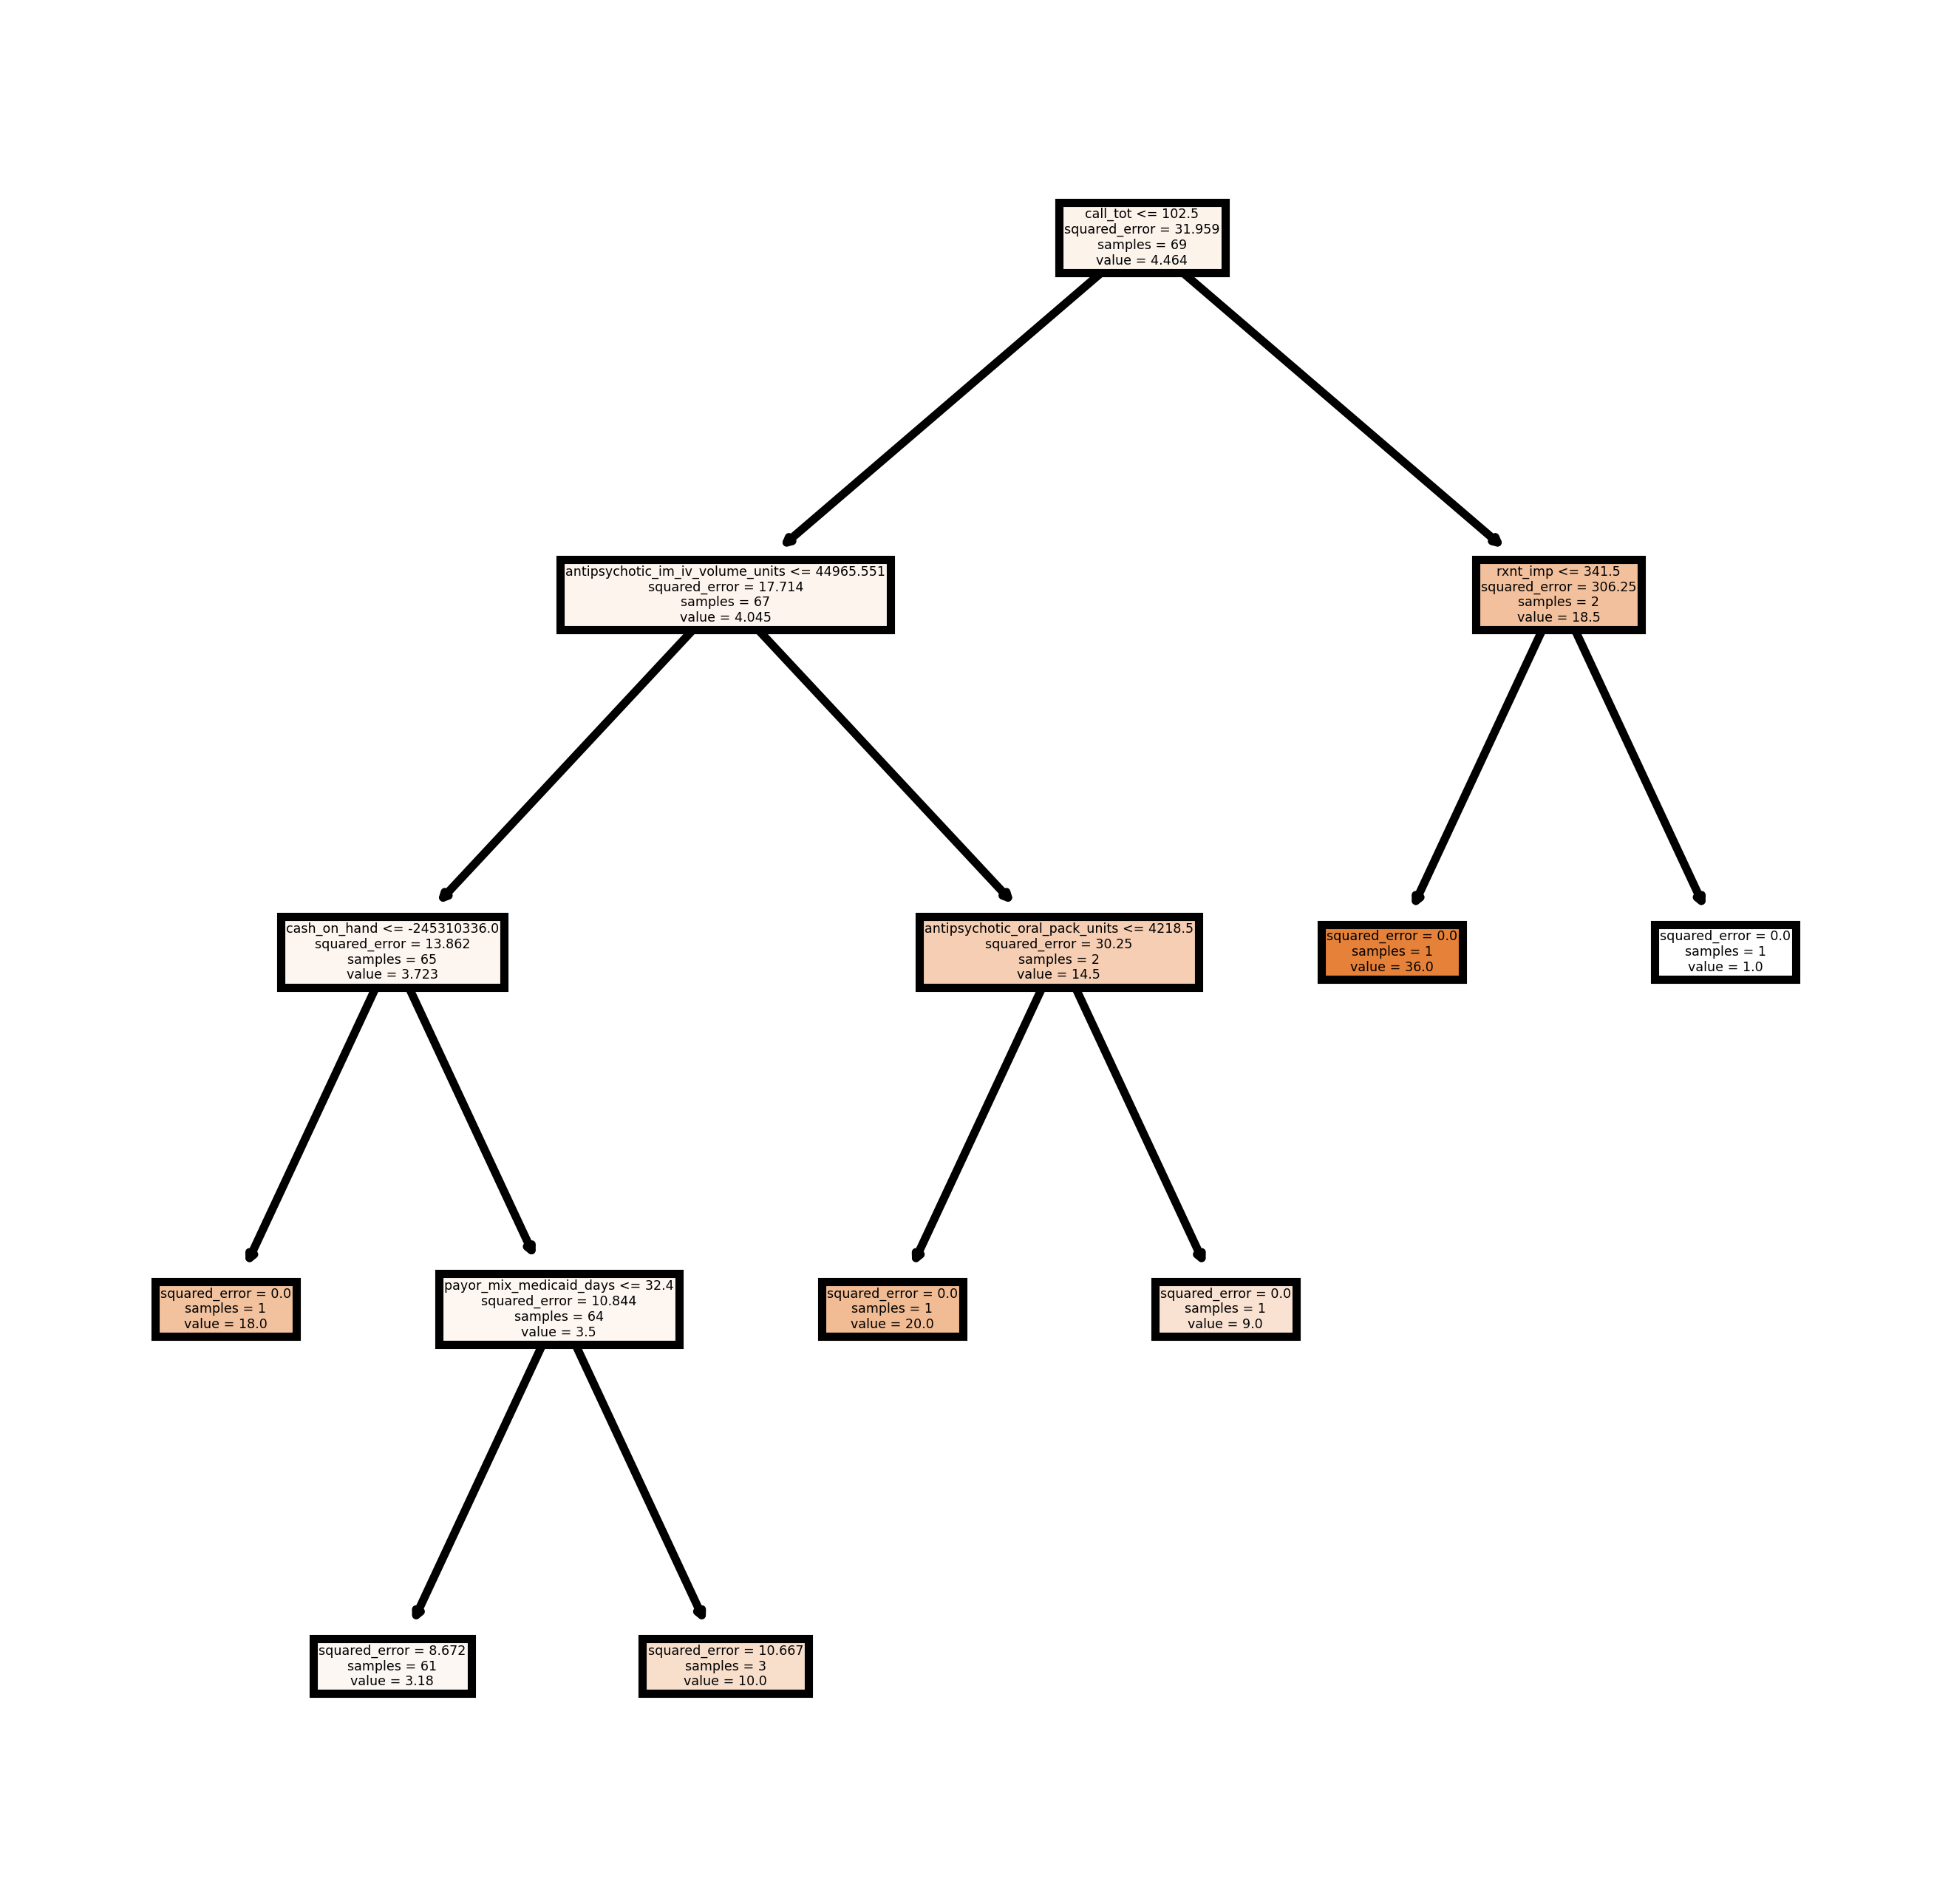

In [201]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(dtree_full, feature_names=dtree_full.feature_names_in_, filled=True)
fig.savefig('tree_viz_2.png')

# Final Model Fitting

In [202]:
modeling = mmm_modeling.MMMModeling()

In [243]:
# modeling
channels = ['speaker_npi_ct', 'pp_imp_tot', 'rxnt_imp', 'webmd_imp_tot', 'call_tot']
other = non_media_num + binary + [x for x in df_m.columns if (x.startswith('formulary_type_')) | (x.startswith('segmentation_')) | (x.startswith('flag_'))]
X = df_m[channels + other]
y = df_m['shipped_quantity']
model = modeling.rf_regressor(df_m, X.columns.tolist(), 'shipped_quantity', None)

In [244]:
# performance
model['performance']

{'full': {'r2': 0.8278670482925419,
  'rmse': 2.3454569098455056,
  'mape': 0.6681770761444674},
 'train': {'r2': 0.8509538748109624,
  'rmse': 2.3115347125389936,
  'mape': 0.5938345959595959},
 'test': {'r2': 0.016605813953488147,
  'rmse': 4.0492706574323805,
  'mape': 1.4893663677592248}}

In [245]:
# importance
model['importance']

,feature,importance,std
4,call_tot,0.276204,0.221492
6,antipsychotic_im_iv_volume_units,0.112602,0.124006
23,cash_on_hand,0.094451,0.112052
18,payor_mix_medicaid_days,0.057996,0.087595
7,antipsychotic_im_iv_wac_dollars,0.039497,0.081574
5,antipsychotic_im_iv_pack_units,0.036385,0.068241
19,payor_mix_private/self-pay/other_days,0.032994,0.076005
21,net_income,0.028819,0.081698
20,net_patient_revenue,0.024561,0.076078
9,antipsychotic_oral_volume_units,0.021388,0.068525


In [136]:
# scatter plot of predictions
plot_df = pd.DataFrame({'preds': model['df_preds_full']['preds_full'],
                        'actual': model['df_preds_full']['shipped_quantity']})
fig = px.scatter(plot_df, x="preds", y='actual', title="Full Data - Model trained on full data")
fig.show()

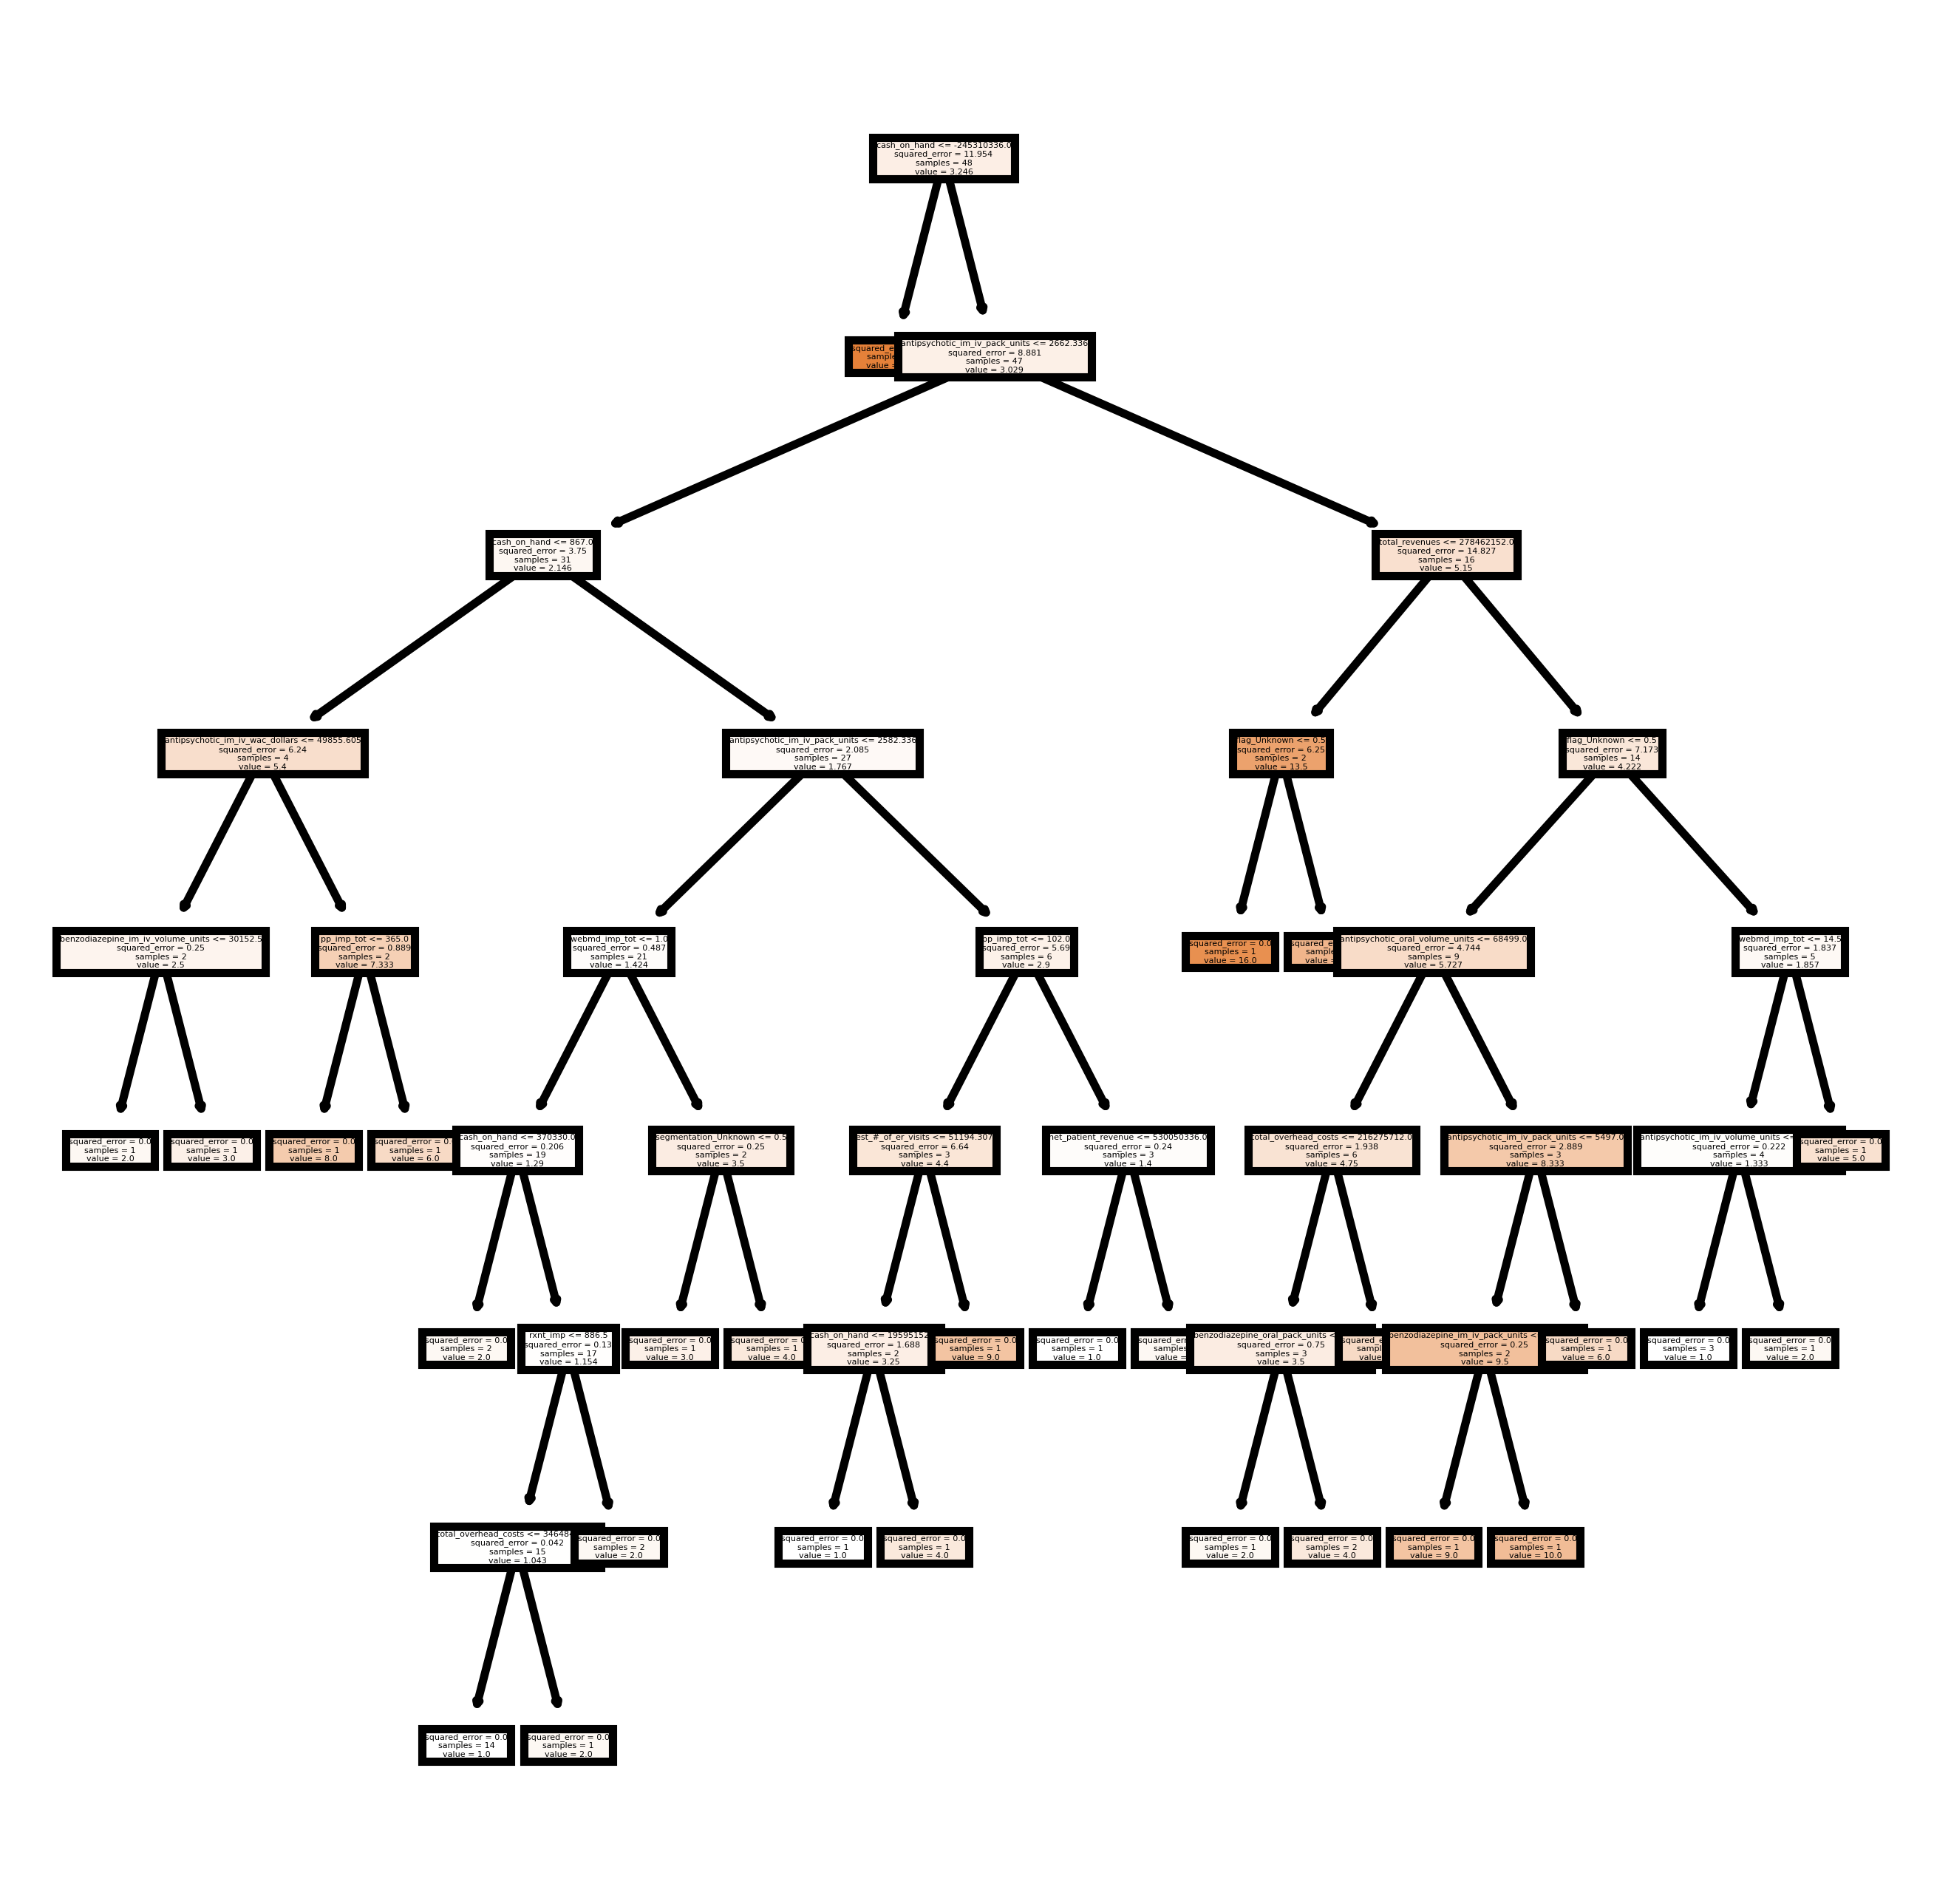

In [246]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model['full_model'].estimators_[0], feature_names=model['full_model'].feature_names_in_, filled=True)
fig.savefig('tree_viz.png')

# Response Curves - Overall

In [209]:
response_curves = mmm_response_curves.MMMResponseCurves()

In [247]:
channels = ['speaker_npi_ct', 'pp_imp_tot', 'rxnt_imp', 'webmd_imp_tot', 'call_tot']
other = non_media_num + binary + [x for x in df_m.columns if (x.startswith('formulary_type_')) | (x.startswith('segmentation_')) | (x.startswith('flag_'))]
X = df_m[channels + other]

In [248]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
speaker_npi_ct,69.0,1.594203e-01,5.589693e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
pp_imp_tot,69.0,1.508072e+03,1.937730e+03,0.000000e+00,4.700000e+01,5.130000e+02,2.636000e+03,7.654000e+03
rxnt_imp,69.0,4.339130e+02,6.623170e+02,0.000000e+00,0.000000e+00,1.350000e+02,6.310000e+02,3.373000e+03
webmd_imp_tot,69.0,2.275362e+00,5.948020e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01
call_tot,69.0,3.036232e+01,4.355962e+01,0.000000e+00,2.000000e+00,1.700000e+01,4.100000e+01,2.990000e+02
antipsychotic_im_iv_pack_units,69.0,2.583672e+03,2.233645e+03,3.000000e+00,1.210000e+03,2.368000e+03,3.135000e+03,1.038600e+04
antipsychotic_im_iv_volume_units,69.0,7.773725e+03,1.265190e+04,3.000000e+00,1.417400e+03,3.481000e+03,7.773725e+03,7.910300e+04
antipsychotic_im_iv_wac_dollars,69.0,1.249380e+05,2.387169e+05,7.500000e+01,1.254867e+04,4.779340e+04,1.249380e+05,1.685755e+06
antipsychotic_oral_pack_units,69.0,1.015328e+03,1.427726e+03,6.000000e+00,1.820000e+02,6.190000e+02,1.015328e+03,7.360000e+03
antipsychotic_oral_volume_units,69.0,7.188674e+04,1.140811e+05,5.500000e+02,1.390000e+04,4.085000e+04,7.188674e+04,6.945980e+05


In [249]:
# overall response curves
channel1 = response_curves.responses(model['full_model'], X, 'speaker_npi_ct', 10, 1)
channel2 = response_curves.responses(model['full_model'], X, 'pp_imp_tot', 5000, 20)
channel3 = response_curves.responses(model['full_model'], X, 'rxnt_imp', 3000, 20)
channel4 = response_curves.responses(model['full_model'], X, 'webmd_imp_tot', 100, 1)
channel5 = response_curves.responses(model['full_model'], X, 'call_tot', 100, 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.28it/s]
D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

 37%|████████████████████████████████████████████████▋                                                                                    | 92/251 [00:01<00:02, 65.52it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, 

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

 55%|█████████████████████████████████████████████████████████████████████████                                                           | 139/251 [00:02<00:01, 58.87it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\

 63%|███████████████████████████████████████████████████████████████████████████████████                                                 | 158/251 [00:02<00:01, 59.76it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 178/251 [00:03<00:01, 56.89it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 220/251 [00:03<00:00, 54.64it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 107/151 [00:01<00:00, 60.30it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 133/151 [00:02<00:00, 57.60it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:02<00:00, 61.53it/s]
D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

overflow encountered in power

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 98/101 [00:01<00:00, 63.35it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

In [212]:
response_curves.plot(channel1['resp_df'], 'touches', ['speaker_npi_ct', 'speaker_npi_ct_hill_estimate'])

In [213]:
response_curves.plot(channel2['resp_df'], 'touches', ['pp_imp_tot', 'pp_imp_tot_hill_estimate'])

In [214]:
response_curves.plot(channel3['resp_df'], 'touches', ['rxnt_imp', 'rxnt_imp_hill_estimate'])

In [215]:
response_curves.plot(channel4['resp_df'], 'touches', ['webmd_imp_tot', 'webmd_imp_tot_hill_estimate'])

In [250]:
response_curves.plot(channel5['resp_df'], 'touches', ['call_tot', 'call_tot_hill_estimate'])

In [ ]:
#overall_resp = pd.concat([channel1['resp_df'],
#                          channel2['resp_df'].drop(['touches'], axis=1),
#                          channel3['resp_df'].drop(['touches'], axis=1),
#                          channel4['resp_df'].drop(['touches'], axis=1),
#                          channel5['resp_df'].drop(['touches'], axis=1),
#                          channel6['resp_df'].drop(['touches'], axis=1),
#                          channel7['resp_df'].drop(['touches'], axis=1),
#                          channel8['resp_df'].drop(['touches'], axis=1),
#                          channel9['resp_df'].drop(['touches'], axis=1)], axis=1)
#fig = response_curves.plot(overall_resp, 'touches', channels + ['competitor_sales_B'])
#fig.update_layout(xaxis_title='Weekly Spend', yaxis_title='Revenue Impact')
#fig

In [34]:
# overall response curves for top non-media
#nonmedia1 = response_curves.responses(model['full_model'], X, 'payor_mix_medicaid_days', 1, 0.01)
nonmedia2 = response_curves.responses(model['full_model'], X, 'net_patient_revenue', 1000000000, 2000000)
nonmedia3 = response_curves.responses(model['full_model'], X, 'antipsychotic_im_iv_volume_units', 20000, 200)

 19%|███████████████████████████████████▊                                                                                                                                                         | 95/501 [00:01<00:06, 63.09it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

 32%|███████████████████████████████████████████████████████████▋                                                                                                                                | 159/501 [00:02<00:06, 54.94it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 263/501 [00:04<00:04, 56.54it/s]D:\Users\hartsi

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 281/501 [00:04<00:03, 56.08it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 325/501 [00:05<00:03, 55.39it/s]D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 344/501 [00:06<00:02, 57.15it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsi

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 363/501 [00:06<00:02, 57.76it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 405/501 [00:07<00:01, 55.22it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 447/501 [00:07<00:00, 56.11it/s]D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 467/501 [00:08<00:00, 59.82it/s]D:\Users\hartsi

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 100/101 [00:01<00:00, 59.75it/s]D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:139: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 61.74it/s]
D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\

Error - curve_fit failed


In [35]:
response_curves.plot(nonmedia2['resp_df'], 'touches', ['net_patient_revenue', 'net_patient_revenue_hill_estimate'])

In [36]:
response_curves.plot(nonmedia3['resp_df'], 'touches', ['antipsychotic_im_iv_volume_units', 'antipsychotic_im_iv_volume_units_hill_estimate'])

# Response Curves - Segments

In [147]:
segment = 'segmentation'
channels = ['speaker_npi_ct', 'pp_imp_tot', 'rxnt_imp', 'webmd_imp_tot', 'call_tot']
other = non_media_num + binary + [x for x in df_t.columns if (x.startswith('formulary_type_')) | (x.startswith('segmentation_')) | (x.startswith('flag_'))]
segments = [x for x in df_t.columns if x.startswith(f"{segment}_")]
X = df_t[channels + other + [segment]]
X[segments] = 0

D:\Users\hartsingh\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3645: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
channel1_segment = response_curves.responses_segment(model['full_model'], X, 'speaker_npi_ct', 10, 1, segment)

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mm

In [149]:
channel1_segment['fig_hill']

In [150]:
channel2_segment = response_curves.responses_segment(model['full_model'], X, 'pp_imp_tot', 5000, 20, segment)

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mm

In [151]:
channel2_segment['fig_hill']

In [152]:
channel3_segment = response_curves.responses_segment(model['full_model'], X, 'rxnt_imp', 3000, 20, segment)

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


In [153]:
channel3_segment['fig_hill']

In [154]:
channel4_segment = response_curves.responses_segment(model['full_model'], X, 'webmd_imp_tot', 100, 1, segment)

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mm

In [155]:
channel4_segment['fig_hill']

In [156]:
channel5_segment = response_curves.responses_segment(model['full_model'], X, 'call_tot', 100, 1, segment)

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mm

In [157]:
channel5_segment['fig_hill']

# Response Curves - waves

In [158]:
segment = 'flag'
channels = ['speaker_npi_ct', 'pp_imp_tot', 'rxnt_imp', 'webmd_imp_tot', 'call_tot']
other = non_media_num + binary + [x for x in df_t.columns if (x.startswith('formulary_type_')) | (x.startswith('segmentation_')) | (x.startswith('flag_'))]
segments = [x for x in df_t.columns if x.startswith(f"{segment}_")]
X = df_t[channels + other + [segment]]
X[segments] = 0

D:\Users\hartsingh\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3645: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [159]:
channel1_segment = response_curves.responses_segment(model['full_model'], X, 'speaker_npi_ct', 10, 1, segment)
channel1_segment['fig_hill']

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



In [160]:
channel2_segment = response_curves.responses_segment(model['full_model'], X, 'pp_imp_tot', 5000, 20, segment)
channel2_segment['fig_hill']

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



In [161]:
channel3_segment = response_curves.responses_segment(model['full_model'], X, 'rxnt_imp', 3000, 20, segment)
channel3_segment['fig_hill']

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



Error - curve_fit failed


In [162]:
channel4_segment = response_curves.responses_segment(model['full_model'], X, 'webmd_imp_tot', 100, 1, segment)
channel4_segment['fig_hill']

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



In [163]:
channel5_segment = response_curves.responses_segment(model['full_model'], X, 'call_tot', 100, 1, segment)
channel5_segment['fig_hill']

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\promotional_response_rf\research\mmm_response_curves.py:24: RuntimeWarning:

divide by zero encountered in power



# Next Steps

In [172]:
# interesting findings but this model does not account for any adstock or lag dv
# feature selection to reduce feature space - pick best feature from each category